In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize
# from simpeg import dask
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation, MetaSimulation


Solver = get_default_solver()


directory = "../synthetic-data-10m"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

files.remove("rx_locs.txt")
rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")
# rx_locs[:, 1] =

files.remove("rx_times.txt")
rx_times = np.loadtxt(f"{directory}/rx_times.txt")


In [2]:
dobs_dict = {}

for f in files:
    key = f.split(".")[0]
    dobs_dict[key] = np.loadtxt(f"{directory}/{f}")
    
data_dict = {}
for key, value in dobs_dict.items():
    source_list = []
    for i in range(rx_locs.shape[0]):
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)

    full_survey = tdem.Survey(source_list)

    data_dict[key] = Data(survey=full_survey, dobs=value)



In [3]:
n_times_invert = 20
data_dict_invert = {}
    
for key, value in dobs_dict.items():

    source_list = []

    for i in range(rx_locs.shape[0]):
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)

    survey = tdem.Survey(source_list)

    data_dict_invert[key] = Data(
        survey=survey,
        dobs=(value.reshape(rx_locs.shape[0], len(rx_times))[:, :n_times_invert]).flatten(),
        relative_error=0.1,
        noise_floor=1e-11
    )

In [4]:
src = source_list[0]

In [5]:
rx = src.receiver_list[0]

In [6]:
rx.locations[0, 1]

np.float64(0.0)

In [7]:
rx.times

array([0.0001    , 0.00011836, 0.00014008, 0.0001658 , 0.00019624,
       0.00023226, 0.0002749 , 0.00032536, 0.00038509, 0.00045579,
       0.00053946, 0.00063849, 0.0007557 , 0.00089443, 0.00105862,
       0.00125296, 0.00148297, 0.00175521, 0.00207742, 0.00245878])

In [8]:
data_invert = data_dict_invert["target_0"]
survey = data_invert.survey

In [9]:
downsample = 1
source_list_downsampled = data_invert.survey.source_list[::downsample]

with open("survey.txt", "w") as f:
    f.write(f"N_TRX {len(source_list_downsampled)}\n\n")

    for src in source_list_downsampled: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]} {src.location[1]} {src.location[2]} {src.radius} 0 0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for t in rx_times[:n_times_invert]:
            rx = src.receiver_list[0]
            f.write(f"{rx.locations[0, 0]} {rx.locations[0, 1]} {rx.locations[0, 2]} {t}\n")
        f.write("\n")
            


        

In [100]:
src = survey.source_list[0]
rx = src.receiver_list[0]
data_invert[src, rx]

array([-6.55434462e-09, -4.63707831e-09, -3.32808904e-09, -2.36915869e-09,
       -1.66094531e-09, -1.15095849e-09, -7.89255554e-10, -5.34561600e-10,
       -3.57517766e-10, -2.39363793e-10, -1.58666024e-10, -1.03423493e-10,
       -6.59916590e-11, -4.14325693e-11, -2.61372424e-11, -1.66247136e-11,
       -1.03789112e-11, -6.38048911e-12, -3.89142202e-12, -2.36408146e-12])

In [12]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")

In [13]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [17]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]
target_z = np.r_[-200, -20]

In [18]:
models = {}

target_x = np.r_[-400, 400]
target_y = np.r_[-500, 500]
target_z_center = -60
target_thickness = 40

# background model
background = np.ones(ubc_mesh.n_cells) * sigma_air
background[ubc_mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        ubc_mesh, target_x_center=-100, target_z_center=target_z_center, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=target_x, 
        target_ylim=target_y,
        target_zlim=target_z
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



In [21]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, "target_0.con", models["target_0"])

In [22]:
relative_error = 0.05
noise_floor = 1e-13

In [23]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [24]:
dobs = load_pre_file("dpred-fwd.txt")

In [29]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))

In [30]:
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-1]

In [32]:
dobs_values

array([[6.202570e-09, 6.498853e-09, 6.814806e-09, ..., 6.814806e-09,
        6.498853e-09, 6.202570e-09],
       [4.424605e-09, 4.631755e-09, 4.854142e-09, ..., 4.854142e-09,
        4.631755e-09, 4.424605e-09],
       [3.085258e-09, 3.225231e-09, 3.377324e-09, ..., 3.377324e-09,
        3.225231e-09, 3.085258e-09],
       ...,
       [5.575266e-12, 5.634433e-12, 5.733682e-12, ..., 5.733682e-12,
        5.634433e-12, 5.575266e-12],
       [3.456942e-12, 3.489547e-12, 3.541377e-12, ..., 3.541377e-12,
        3.489547e-12, 3.456942e-12],
       [2.138133e-12, 2.155654e-12, 2.182125e-12, ..., 2.182125e-12,
        2.155654e-12, 2.138133e-12]])

In [36]:
data_invert.dobs = discretize.utils.mkvc(dobs_values)

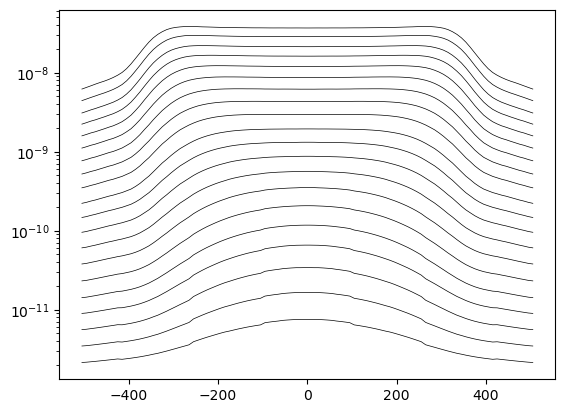

In [37]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(rx_locs[:, 0], data_invert.dobs.reshape(102, 20), color="k", lw=0.5);
# ax.semilogy(rx_locs[::3, 0], dpred_values.T, "C0o", ms=2);

In [41]:

source_list = data_invert.survey.source_list

with open("dobs.txt", "w") as f:
    f.write(f"IGNORE -9.9999000e+004\n")
    f.write(f"N_TRX {len(source_list)}\n\n")

    for src in source_list: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]}\t{src.location[1]}\t{src.location[2]}\t{src.radius}\t0\t0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for i, t in enumerate(rx_times[:n_times_invert]):
            rx = src.receiver_list[0]
            datum = -data_invert[src, rx][i]
            std = np.abs(datum) * relative_error + noise_floor
            f.write(
                f"{rx.locations[0, 0]}\t{rx.locations[0, 1]}\t{rx.locations[0, 2]}\t{t} "+
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # E data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # H data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t{datum}\t{std}\n"
            )
            
        f.write("\n")
            


        

In [42]:
time_steps = [
    (1e-6, 30),
    (3e-6, 30),
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]

In [43]:
full_time_mesh = np.cumsum(np.hstack([0, discretize.utils.unpack_widths(time_steps)]))
with open("waveform.txt", "w") as f:
    for i, t in enumerate(full_time_mesh): 
        if i == 0:
            f.write(f"{t} \t 1\n")
        else:
            f.write(f"{t} \t 0\n")

In [105]:
# fname = "dpred0.txt"
# with open(fname, 'r') as f:
#     lines = f.readlines()



In [108]:
len(dpred["transmitters"])

34

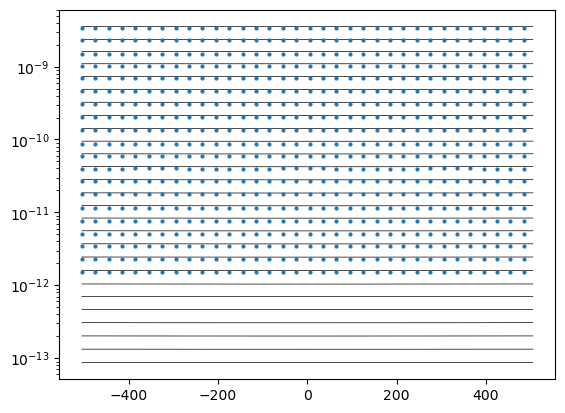

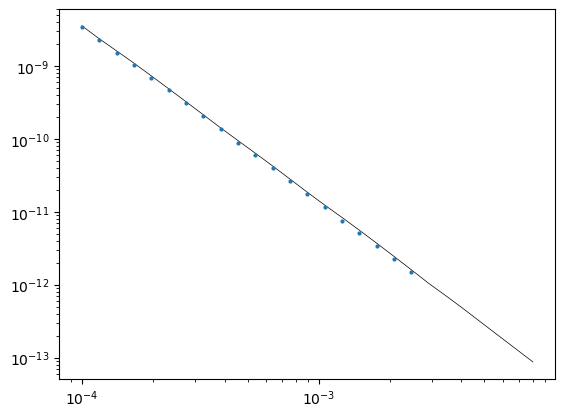

In [86]:
fig, ax=plt.subplots(1, 1)
ax.loglog(rx_times, -dobs_dict["background"].reshape(102, 27)[0, :], color="k", lw=0.5);
ax.loglog(rx_times[:20], dpred_values[:, 0], "o", ms=2);


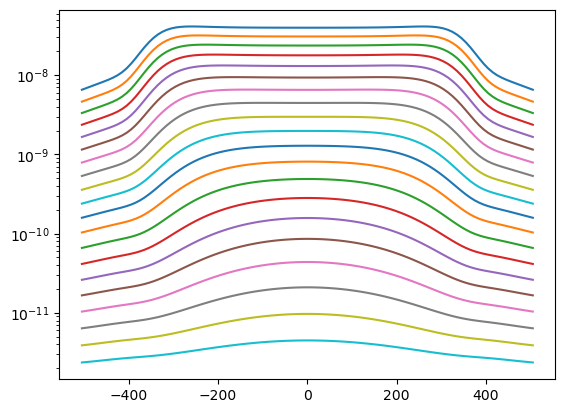

In [126]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(rx_locs[:, 0], -data_invert.dobs.reshape( 102, 20)); 

In [90]:
-dobs_dict["background"][0] - dpred_values[0, 0]

np.float64(1.181989648186056e-10)

In [20]:
ubc_model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "inv_002.con")

In [ ]:
with open(f"{directory}/true-models.pkl", "rb") as f:
    true_models = pickle.load(f)

simpeg_mesh = discretize.load_mesh(f"{directory}/treemesh.json")

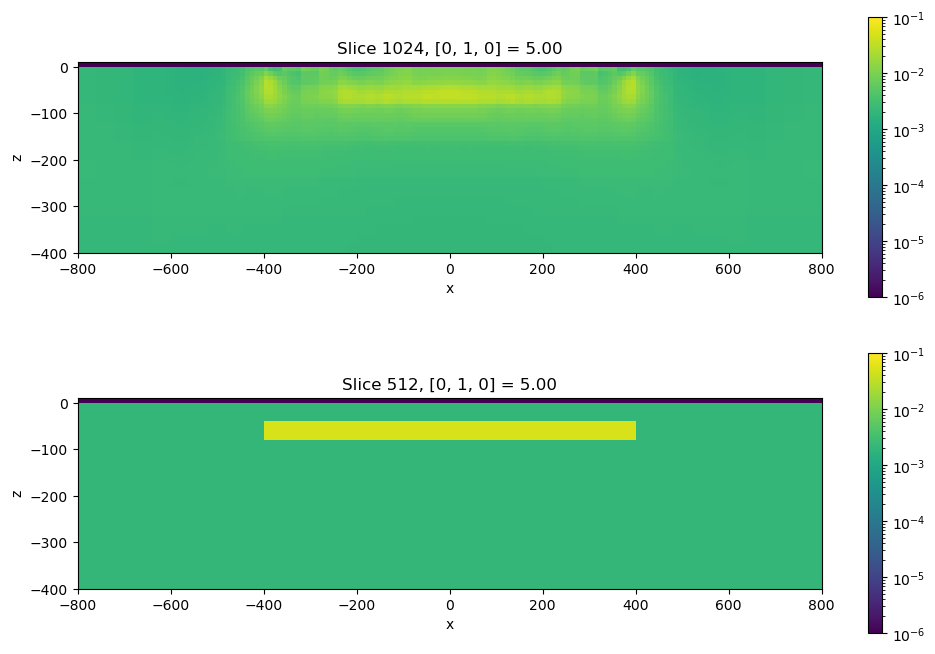

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8)) 

plt.colorbar(ubc_mesh.plot_slice(
    ubc_model, 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[0],
    normal="Y",
    # grid=True,
)[0], ax=ax[0])

plt.colorbar(simpeg_mesh.plot_slice(
    true_models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[1],
    normal="Y"
)[0], ax=ax[1])


for a in ax: 
    a.set_xlim(800* np.r_[-1, 1])
    a.set_ylim(-400, 10)
    a.set_aspect(1)

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/utils/io_utils.py:39: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  data = cls(**jsondict)


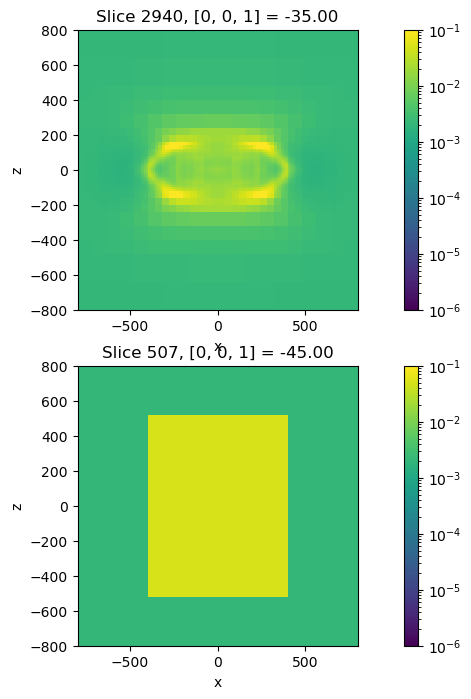

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8)) 

plt.colorbar(ubc_mesh.plot_slice(
    ubc_model, 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[0],
    normal="Z",
    ind=2940,
    # grid=True,
)[0], ax=ax[0])

plt.colorbar(simpeg_mesh.plot_slice(
    true_models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[1],
    normal="Z",
    ind=507,
)[0], ax=ax[1])


for a in ax: 
    a.set_xlim(800* np.r_[-1, 1])
    a.set_ylim(800* np.r_[-1, 1])
    a.set_aspect(1)